1. Create a straight line dataset using the linear regression formula (weight * X + bias).

- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [29]:
import torch
import matplotlib.pyplot as plt

In [30]:
weight, bias = 0.3, 0.9
x_data = torch.arange(0, 10, 0.1).unsqueeze(dim=1)
# if we don't unsqueeze here, it will report a mistake: "mat1 and mat2 shapes cannot be multiplied (1x80 and 1x1)"
y_data = weight * x_data + bias
x_data.shape, y_data.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [31]:
split = int(0.8 * len(x_data))
x_train, x_test = x_data[:split], x_data[split:]
y_train, y_test = y_data[:split], y_data[split:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

The documentation of Pylot: https://matplotlib.org/stable/tutorials/pyplot.html

In [32]:
def plot_predictions(train_data = x_train,
                     train_label = y_train,
                     test_data = x_test,
                     test_label = y_test,
                     predictions = None):
    plt.figure(figsize=(10,6))
    plt.plot(train_data, train_label, 'r--', label = "Train Data")
    plt.plot(test_data, test_label, 'g--', label = "Test Data")
    if predictions is not None:
        plt.plot(test_data, predictions, 'b--', label = "Predictions")
    plt.title("Visualization of data")
    plt.legend() # display the label in the top-left corner of the figure
    plt.show()


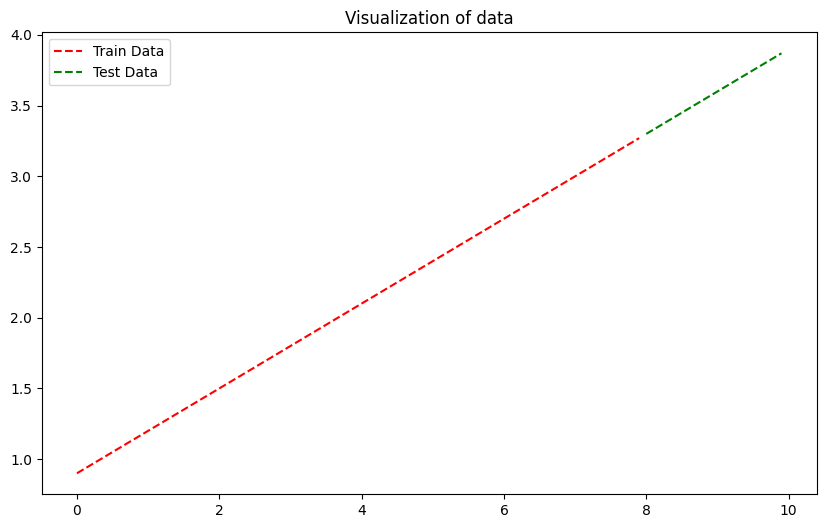

In [33]:
plot_predictions()

2. Build a PyTorch model by subclassing nn.Module.
- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().
Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [34]:
from torch import nn

In [35]:
class LinearModel(nn.Module):
    def __init__(self): # initialize the parameters
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1) # the numbers of input and output features are necessary
    def forward(self, x):
        return self.linear_layer(x)

In [36]:
torch.manual_seed(42)

model_1 = LinearModel()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.

In [37]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01) # need to pass the params into optimizer

In [38]:
for epoch in range(300):
    # training
    model_1.train() # 1. set training mode
    train_preds = model_1(x_train) # 3. make training predictions
    train_loss = loss_fn(train_preds, y_train) # 3. calculate training loss
    optimizer.zero_grad() # 4. reset gradients
    train_loss.backward() # 5. pass the loss backward
    optimizer.step() # 6. update the parameters

    # testing
    model_1.eval() # 1. set evaluating mode
    with torch.inference_mode(): # 2. set inference mode
        test_preds = model_1(x_test) # 3. make testing predictions
        test_loss = loss_fn(test_preds, y_test) # 4. calculate testing loss
        if epoch % 20 == 0 :
            print(f"Epoch: {epoch}, training loss: {train_loss}, testing loss: {test_loss}")

Epoch: 0, training loss: 1.7672735452651978, testing loss: 3.7248260974884033
Epoch: 20, training loss: 0.07500652968883514, testing loss: 0.36033564805984497
Epoch: 40, training loss: 0.08991290628910065, testing loss: 0.2610540986061096
Epoch: 60, training loss: 0.025813108310103416, testing loss: 0.3651537001132965
Epoch: 80, training loss: 0.03732060268521309, testing loss: 0.3143962323665619
Epoch: 100, training loss: 0.021645430475473404, testing loss: 0.3375717103481293
Epoch: 120, training loss: 0.015559317544102669, testing loss: 0.34503307938575745
Epoch: 140, training loss: 0.01305948942899704, testing loss: 0.3475329279899597
Epoch: 160, training loss: 0.012309560552239418, testing loss: 0.3482828736305237
Epoch: 180, training loss: 0.012309560552239418, testing loss: 0.3482828736305237
Epoch: 200, training loss: 0.012309560552239418, testing loss: 0.3482828736305237
Epoch: 220, training loss: 0.012309560552239418, testing loss: 0.3482828736305237
Epoch: 240, training loss:

4. Make predictions with the trained model on the test data.
- Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

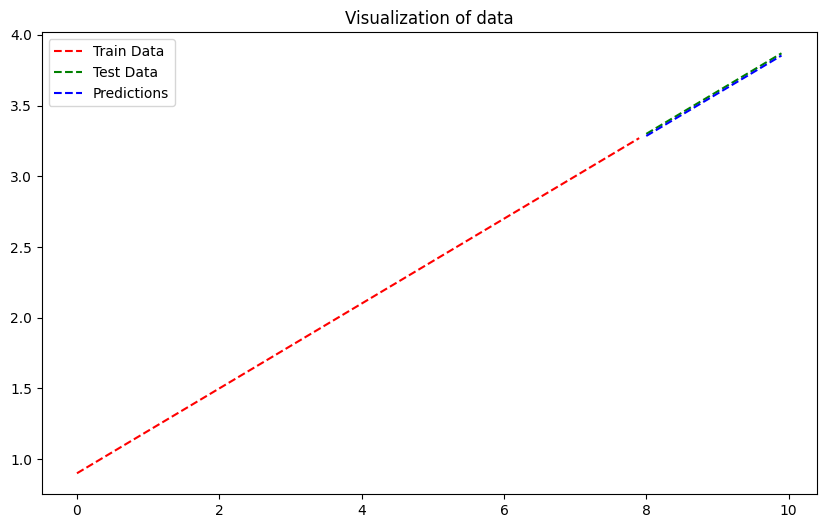

In [ ]:
x_test_preds = model_1(x_test)
plot_predictions(predictions=x_test_preds.detach().numpy()) # the reason is below

Note: Here is why x_test_preds needs to be detached:
1. x_test_preds is the output tensor of the model, rather than a manually created ordinary tensor.
2. It has the requires_grad attribute set to True, which means it automatically tracks all the gradient computations (i.e., it is tied to the model's computational graph for backpropagation).
3. Unlike vanilla (normal) tensors, this gradient-tracking tensor cannot be directly used for subsequent operations (e.g., converting to a NumPy array for plotting with Matplotlib).
Therefore, detaching x_test_preds from the computational graph is an essential step.

In [ ]:
print("x_test_preds.grad_fn:", x_test_preds.grad_fn)  # it's generated by matrix multiplication
print("x_test.grad_fn:", x_test.grad_fn) # it's vanilla tensors without gradient

x_test_preds.grad_fn: <AddmmBackward0 object at 0x302969d00>
x_test.grad_fn: None


5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [ ]:
from pathlib import Path # Modern OOP tool for cross-platform file path handling (simpler than os.path)

models_path = Path("models")
model_1_name = Path("01_pytorch_practice_model_1.pth")
model_1_path = models_path / model_1_name
torch.save(model_1.state_dict(), f = model_1_path) # first param is object, second is save path

In [50]:
model_2 = LinearModel()
model_2.load_state_dict(torch.load(model_1_path)) # load the params from model_1_path

<All keys matched successfully>

In [ ]:
model_2_preds = model_2(x_test)
model_2_preds == x_test_preds # x_test_preds comes from model_1

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])